In [51]:
import numpy as np
import awkward as ak
import uproot
import vector
import mplhep as hep
import matplotlib.pyplot as plt
import os
from scipy.stats import beta

In [52]:
### FUNCTION DEFINITION ###
def GetMaxMjj(Jets):
    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    jjCombo  = JetCombo.jet1 + JetCombo.jet2
    mjjCombo = np.sqrt(np.abs((jjCombo.E)**2 - (jjCombo.px**2 + jjCombo.py**2 + jjCombo.pz**2)))
    maxmjj   = ak.max(mjjCombo,axis=1)
    return maxmjj

def GetMaxEta(Jets):
    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    etacombo = vector.Spatial.deltaeta(JetCombo.jet1, JetCombo.jet2)
    maxeta   = ak.max(etacombo, axis=1)
    return maxeta

def clopper_pearson_interval(hltPassed, total, confidence):
    alpha = (1 - confidence) / 2
    min = beta.ppf(alpha, hltPassed, total - hltPassed + 1)
    max = beta.ppf(1 - alpha, hltPassed + 1, total - hltPassed)
    return min, max

In [101]:
# Try to change everything here!

### ACCESSING FILES ###
ZBpath = "/Users/raymondkil/Desktop/VBF Trigger/rootfiles/zerobias/" # zb stands for zero bias.
#ZBpath = "/eos/user/j/jkil/SUEP/suep-production/summer23data/zerobias/"
ZBnames = os.listdir(ZBpath)
ZBnames = [x for x in ZBnames if x != '.DS_Store']

# Which Trigger Path?
pt105Analysis       = True
pt105tripleAnalysis = False
pt125Analysis       = False
pt125tripleAnalysis = False

# Which Analysis?
LeadJetPtAnalysis    = False
SubleadJetPtAnalysis = False
MjjAnalysis          = True 
DetaAnalysis         = False

In [102]:
# Trigger path dictionaries (before processing)
if pt105Analysis:
    triggerdict = {
        "leadjetpt": 105,
        "subleadjetpt": 40,
        "mjj": 1000,
        "deta": 3.5
    }

if pt105tripleAnalysis:
    triggerdict = {
        "leadjetpt": 105,
        "subleadjetpt": 40,
        "mjj": 1000,
        "deta": 3.5
    }

if pt125Analysis:
    triggerdict = {
        "leadjetpt": 125,
        "subleadjetpt": 45,
        "mjj": 720,
        "deta": 3.0
    }

if pt125tripleAnalysis:
    triggerdict = {
        "leadjetpt": 125,
        "subleadjetpt": 45,
        "mjj": 720,
        "deta": 3.0
    }

In [103]:
### PROCESSING ###

mjjs, dEtas, HLTpassedJets = [],[],[]
OFFJets = []

for filename in ZBnames:
    print("Processing file {}".format(filename))
    f = uproot.open(ZBpath + filename)
    events = f["Events"]
    HLTJets = ak.zip({
        "pt105":       events["HLT_VBF_DiPFJet105_40_Mjj1000_Detajj3p5"].array(),
        "pt105triple": events["HLT_VBF_DiPFJet105_40_Mjj1000_Detajj3p5_TriplePFJet"].array(),
        "pt125":       events["HLT_VBF_DiPFJet125_45_Mjj720_Detajj3p0"].array(),
        "pt125triple": events["HLT_VBF_DiPFJet125_45_Mjj720_Detajj3p0_TriplePFJet"].array()
    })

    OFFJet = vector.zip({
        "pt": events["Jet_pt"].array(),
        "eta": events["Jet_eta"].array(),
        "phi": events["Jet_phi"].array(),
        "mass": events["Jet_mass"].array()
    })
    HLTpassedJet = OFFJet[HLTJets.pt105] # should change according to trigger path
    HLTpassedJets = np.concatenate((HLTpassedJets, HLTpassedJet))

    nJetCut = (ak.num(OFFJet)>=2)
    OFFJet = OFFJet[nJetCut]

    if not LeadJetPtAnalysis:
        leadPtCut = (ak.max(OFFJet.pt, axis=1)>=triggerdict["leadjetpt"])
        OFFJet = OFFJet[leadPtCut]

    if not SubleadJetPtAnalysis:
        subLeadPtCut = (OFFJet.pt[:,1]>triggerdict["subleadjetpt"])
        OFFJet = OFFJet[subLeadPtCut]

    if not MjjAnalysis:
        mjj  = GetMaxMjj(OFFJet) # This is calculating mjj without mjj cut.
        mjjCut = (mjj>triggerdict["mjj"])
        OFFJet = OFFJet[mjjCut]
        dEtas = np.concatenate((dEtas, dEta)) # This is correct placement!

    if not DetaAnalysis: 
        dEta = GetMaxEta(OFFJet)
        deltaEtaCut = (dEta > triggerdict["deta"])
        OFFJet = OFFJet[deltaEtaCut]
        mjj  = GetMaxMjj(OFFJet) # This is correct placement!

    mjjs    = np.concatenate((mjjs, mjj))
    dEtas   = np.concatenate((dEtas, dEta))
    OFFJets = np.concatenate((OFFJets, OFFJet))

print("number of HLT passed Jets: {}".format(len(HLTpassedJets)))

Processing file 57f0b4cb-e133-4b50-adbb-1ad2aa420831.root
Processing file 629c6996-33b3-4cce-be51-ac00c39040af.root
number of HLT passed Jets: 12


In [104]:
print(OFFJets.pt[:,1])
print(len(OFFJets.pt[:,1]))
print(mjjs)
print(len(mjjs))

[96.4, 81.9, 112, 89.8, 58.4, 48.8, 187, ... 92.9, 62.4, 108, 104, 44.1, 102, 98.5]
125
[1.06e+03, 674, 361, 517, 993, 841, 785, ... 457, 886, 269, 1.58e+03, 264, 989, 550]
125


In [114]:
# Analysis variable dictionaries (after data processing)

if LeadJetPtAnalysis:
    vardict = {
        "plotname": "leadpt",
        "binsize"  : 5,
        "HLTPassedQuantity": HLTpassedJets.pt[:,0],
        "OFFJetQuantity": OFFJets.pt[:,0],
        "maxbin": 210,
        "xlabel": r"Offline $p_T^{leadjet}$ (GeV)",
        "threshold": triggerdict["leadjetpt"],
    }

if SubleadJetPtAnalysis:
    vardict = {
        "plotname": "subleadpt",
        "binsize"  : 2,
        "HLTPassedQuantity": HLTpassedJets.pt[:,1],
        "OFFJetQuantity": OFFJets.pt[:,1],
        "maxbin": 100,
        "xlabel": r"Offline $p_T^{subleadjet}$ (GeV)",
        "threshold": triggerdict["subleadjetpt"],
    }

if MjjAnalysis:
    vardict = {
        "plotname": "mjj",
        "binsize"  : 50,
        "HLTPassedQuantity": GetMaxMjj(HLTpassedJets),
        "OFFJetQuantity": GetMaxMjj(OFFJets),
        "maxbin": 2000,
        "xlabel": r"Offline $M_{jj}$ (GeV)",
        "threshold": triggerdict["mjj"],
    }

if DetaAnalysis:
    vardict = {
        "plotname": "deta",
        "binsize"  : 0.1,
        "HLTPassedQuantity": GetMaxEta(HLTpassedJets),
        "OFFJetQuantity": GetMaxEta(OFFJets),
        "maxbin": 7,
        "xlabel": r"Offline $\Delta\eta$",
        "threshold": triggerdict["deta"],
    }

In [115]:
### EFFICIENCY ###
binsize = vardict["binsize"] # Actually half of binsize
bincenter = np.arange(binsize,vardict["maxbin"],2*binsize)
effs = np.zeros(len(bincenter))
errmin,errmax = np.zeros(len(bincenter)), np.zeros(len(bincenter))

for i in range(len(bincenter)):
    minlim = bincenter[i] - binsize
    maxlim = bincenter[i] + binsize

    nHLT = ak.count_nonzero(ak.where((vardict["HLTPassedQuantity"]>=minlim) & (vardict["HLTPassedQuantity"]<maxlim), True, False))
    nOFF = ak.count_nonzero(ak.where((vardict["OFFJetQuantity"]   >=minlim) & (vardict["OFFJetQuantity"]   <maxlim), True, False))
    errmin[i],errmax[i] = clopper_pearson_interval(nHLT,nOFF,0.95)
    if nOFF!=0: effs[i] = nHLT/nOFF
errmin, errmax = np.nan_to_num(errmin), np.nan_to_num(errmax)

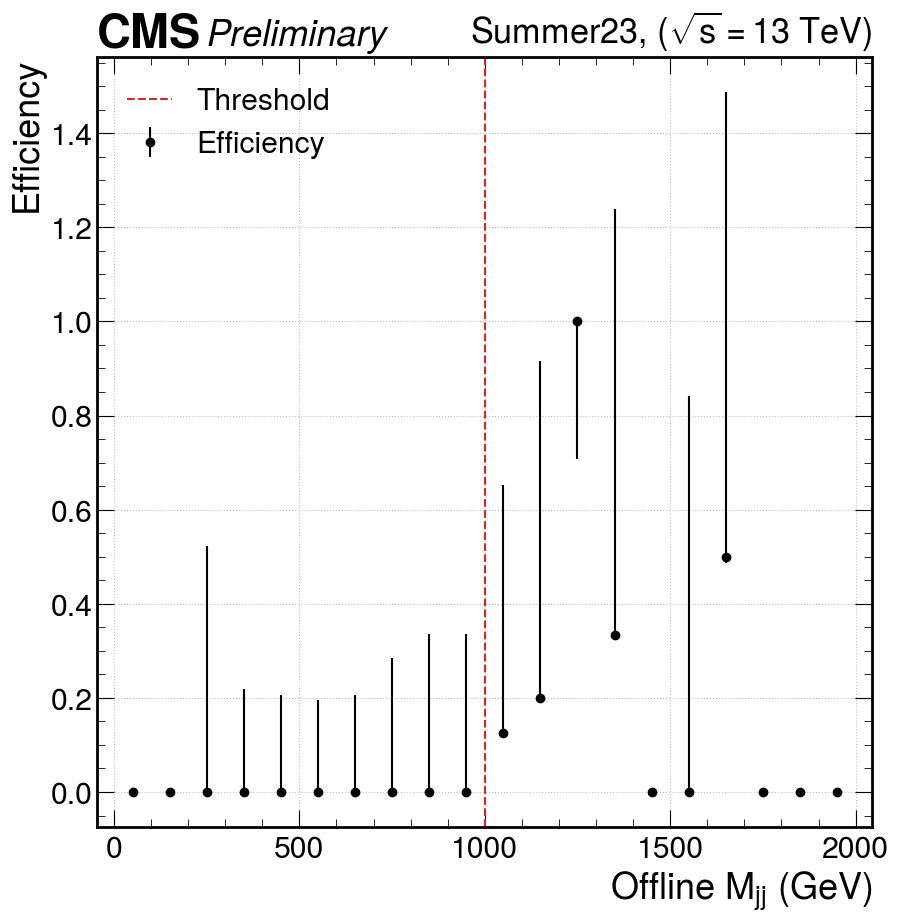

In [116]:
### PLOTTING ###

pltPath = "/eos/user/j/jkil/www/VBFSUEP/efficiency/"
plt.style.use(hep.style.CMS)
plt.figure()

plt.errorbar(bincenter,effs, yerr=[errmin,errmax], marker='o', color="black", label="Efficiency", linestyle='')
plt.grid()
#plt.title(r"Trigger Efficiency of $p_T$")
plt.xlabel(vardict["xlabel"])
plt.ylabel("Efficiency")
hep.cms.text("Preliminary")
hep.cms.lumitext(r"Summer23, ($\sqrt{s}=$13 TeV)")
plt.axvline(x=vardict["threshold"], color='tab:red', label="Threshold", linestyle="--")
plt.legend(loc=2)
#plt.savefig("{0}}{1}Eff.png".format(pltPath,vardict["plotname"]))